In [1]:
!pip install folium
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load datasets
location_data = pd.read_csv('Longitude_Latitude_data.csv')
ecommerce_data = pd.read_csv('Ecommerce_data.csv')

# Merge datasets on a common key (assuming 'customer_state' is the common column)
data = pd.merge(location_data, ecommerce_data, on='customer_state', how='inner')

In [3]:
# Data exploration
print(data.head())
print(data.info())
print(data.describe())

# Data preprocessing for clustering
scaler = StandardScaler()
data[['latitude_scaled', 'longitude_scaled']] = scaler.fit_transform(data[['latitude', 'longitude']])

  state   latitude  longitude customer_state customer_id customer_first_name  \
0    AL  32.318231 -86.902298        Alabama  C_ID_46591                Mary   
1    AL  32.318231 -86.902298        Alabama  C_ID_46596             Raymond   
2    AL  32.318231 -86.902298        Alabama  C_ID_43986                Mary   
3    AL  32.318231 -86.902298        Alabama  C_ID_49227             Tiffany   
4    AL  32.318231 -86.902298        Alabama  C_ID_52644                Mary   

  customer_last_name    category_name  \
0            Phonely  Office Supplies   
1             Hawley       Technology   
2              Clark        Furniture   
3              Seite       Technology   
4               Tran       Technology   

                                        product_name customer_segment  ...  \
0                Large Capacity Hanging Post Binders        Corporate  ...   
1  Razer Kraken 7.1 Surround Sound Over Ear USB G...        Corporate  ...   
2                 Global Geo Office Ta

In [4]:
# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['latitude_scaled', 'longitude_scaled']])

# Summary statistics for clusters
cluster_summary = data.groupby('Cluster').agg(
    total_sales=('sales_per_order', 'sum'),
    total_profit=('profit_per_order', 'sum'),
    total_orders=('order_id', 'count'),
    avg_shipment_delay=('days_for_shipment_real', 'mean'),
).reset_index()
print(cluster_summary)

   Cluster   total_sales   total_profit  total_orders  avg_shipment_delay
0        0  3.323815e+06  353445.420661         16367            3.440582
1        1  4.796310e+06  544864.940612         23361            3.466290
2        2  5.473899e+06  642375.610405         26702            3.467418
3        3  1.552184e+06  182895.689770          7612            3.445875
4        4  8.017455e+06  889487.231172         39228            3.473616


In [5]:
# Visualizing clusters on a map
map_center = [data['latitude'].mean(), data['longitude'].mean()]
folium_map = folium.Map(location=map_center, zoom_start=6)

# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple']
for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=colors[row['Cluster']],
        fill=True,
        fill_color=colors[row['Cluster']],
    ).add_to(folium_map)

# Save the map
folium_map.save('cluster_map.html')

In [6]:
# Load the previously saved cluster summary data
cluster_summary = pd.read_csv('Cluster_Summary.csv')

<Figure size 1000x600 with 0 Axes>

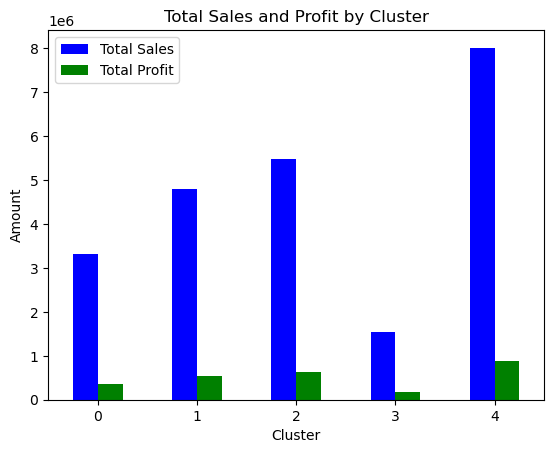

In [7]:
# Plotting total sales and profit by cluster
plt.figure(figsize=(10, 6))
cluster_summary[['total_sales', 'total_profit']].plot(kind='bar', color=['blue', 'green'])
plt.title('Total Sales and Profit by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Amount')
plt.xticks(rotation=0)
plt.legend(['Total Sales', 'Total Profit'])
plt.show()

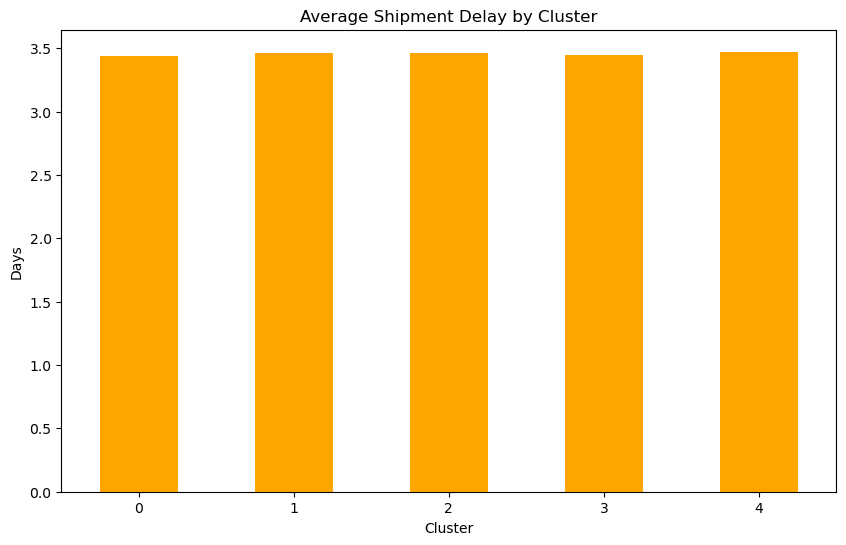

In [8]:
# Plotting average shipment delay by cluster
plt.figure(figsize=(10, 6))
cluster_summary['avg_shipment_delay'].plot(kind='bar', color='orange')
plt.title('Average Shipment Delay by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Days')
plt.xticks(rotation=0)
plt.show()

In [9]:
# Load preprocessed dataset
data = pd.read_csv('Clustered_Data.csv')

# Preparing data for new analyzes
# 1. Clustering by customer segments
segment_data = data[['sales_per_order', 'profit_per_order', 'order_quantity']]
scaler = StandardScaler()
segment_scaled = scaler.fit_transform(segment_data)

kmeans_segment = KMeans(n_clusters=4, random_state=42)
data['Segment_Cluster'] = kmeans_segment.fit_predict(segment_scaled)

# 2. Total sales and profit by product category
category_summary = data.groupby('category_name').agg(
    total_sales=('sales_per_order', 'sum'),
    total_profit=('profit_per_order', 'sum')
).reset_index()

# 3. Shipping delays by region
region_summary = data.groupby('customer_region').agg(
    avg_shipment_delay=('days_for_shipment_real', 'mean'),
    total_orders=('order_id', 'count')
).reset_index()

# 4. Profit - Sales Ratio
data['profit_sales_ratio'] = data['profit_per_order'] / data['sales_per_order']
ratio_summary = data.groupby('Cluster').agg(
    avg_profit_sales_ratio=('profit_sales_ratio', 'mean')
).reset_index()


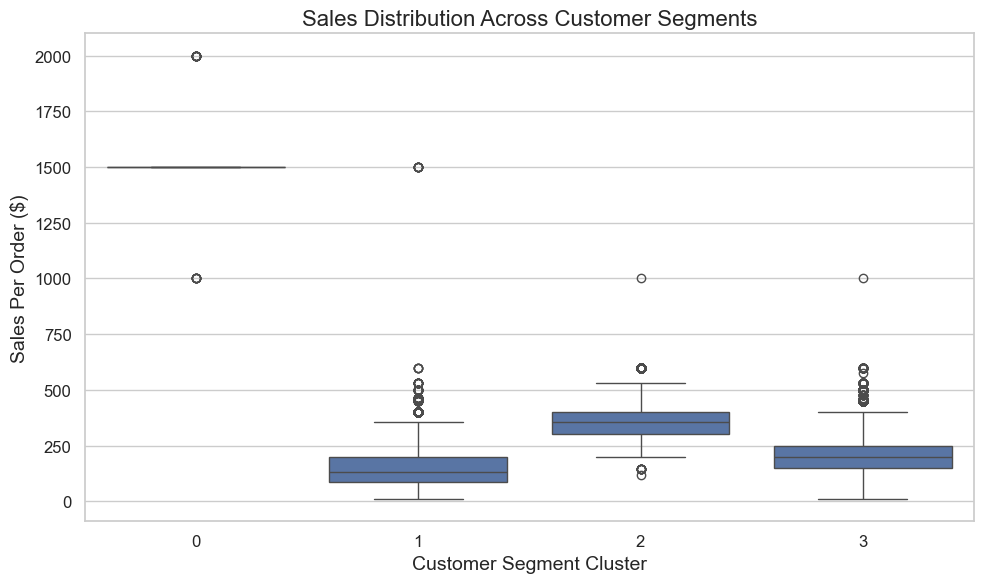

<Figure size 1200x600 with 0 Axes>

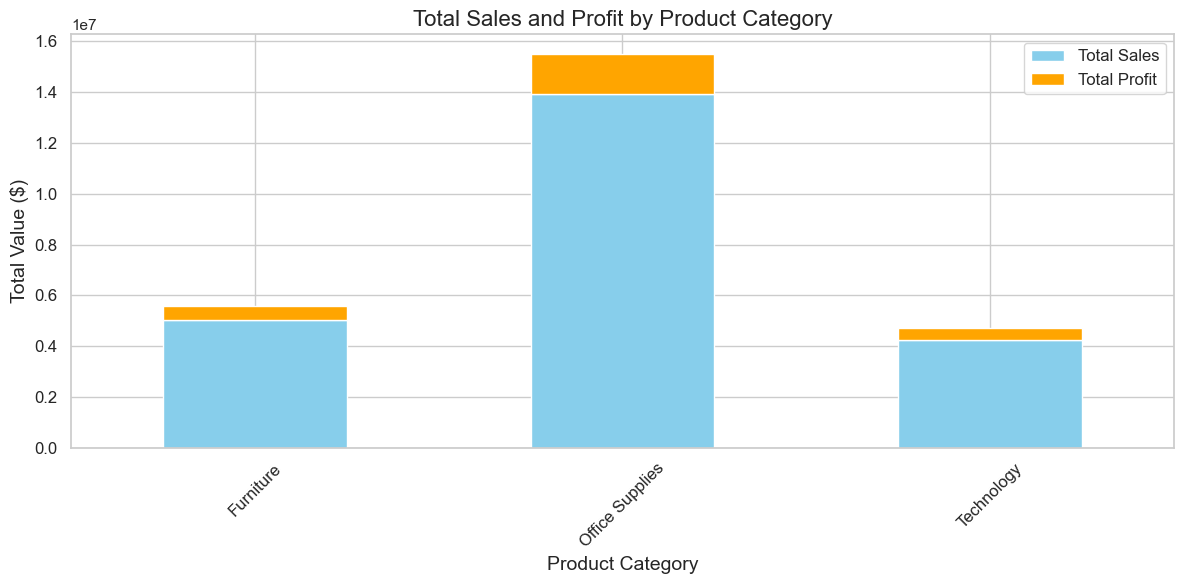

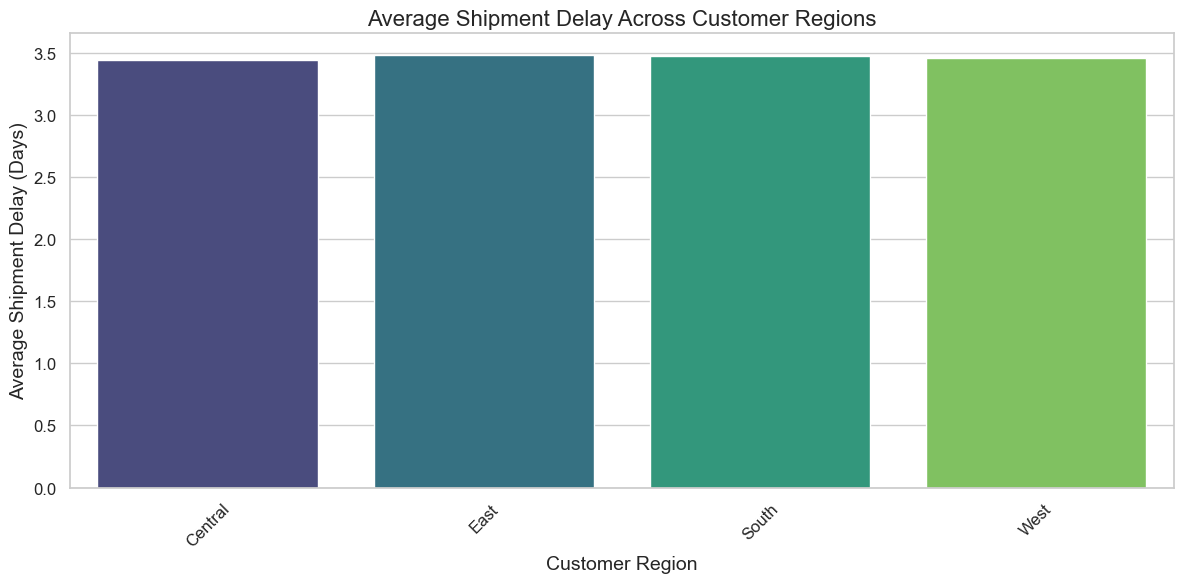

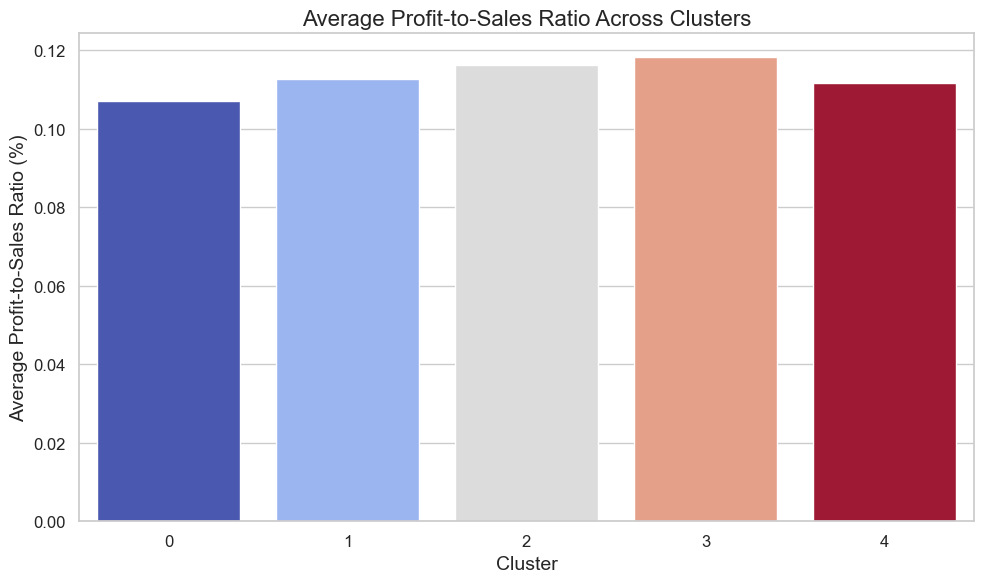

In [10]:
# Visualization
sns.set(style="whitegrid")

# 1. Sales Distribution Across Customer Segments
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment_Cluster', y='sales_per_order', data=data)
plt.title('Sales Distribution Across Customer Segments', fontsize=16)
plt.xlabel('Customer Segment Cluster', fontsize=14)
plt.ylabel('Sales Per Order ($)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 2. Total Sales and Profit by Product Category
plt.figure(figsize=(12, 6))
category_summary.set_index('category_name')[['total_sales', 'total_profit']].plot(
    kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(12, 6)
)
plt.title('Total Sales and Profit by Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Total Value ($)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Total Sales', 'Total Profit'], fontsize=12)
plt.tight_layout()
plt.show()

# 3. Average Shipment Delay by Customer Region
plt.figure(figsize=(12, 6))
sns.barplot(
    x='customer_region',
    y='avg_shipment_delay',
    data=region_summary,
    hue='customer_region',
    dodge=False,
    palette='viridis'
)
plt.title('Average Shipment Delay Across Customer Regions', fontsize=16)
plt.xlabel('Customer Region', fontsize=14)
plt.ylabel('Average Shipment Delay (Days)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([], [], frameon=False)  # Turn off the legend
plt.tight_layout()
plt.show()


# 4.  Average Profit-to-Sales Ratio by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Cluster',
    y='avg_profit_sales_ratio',
    data=ratio_summary,
    hue='Cluster',
    dodge=False,
    palette='coolwarm'
)
plt.title('Average Profit-to-Sales Ratio Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Profit-to-Sales Ratio (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend([], [], frameon=False)  # Turn off the legend
plt.tight_layout()
plt.show()

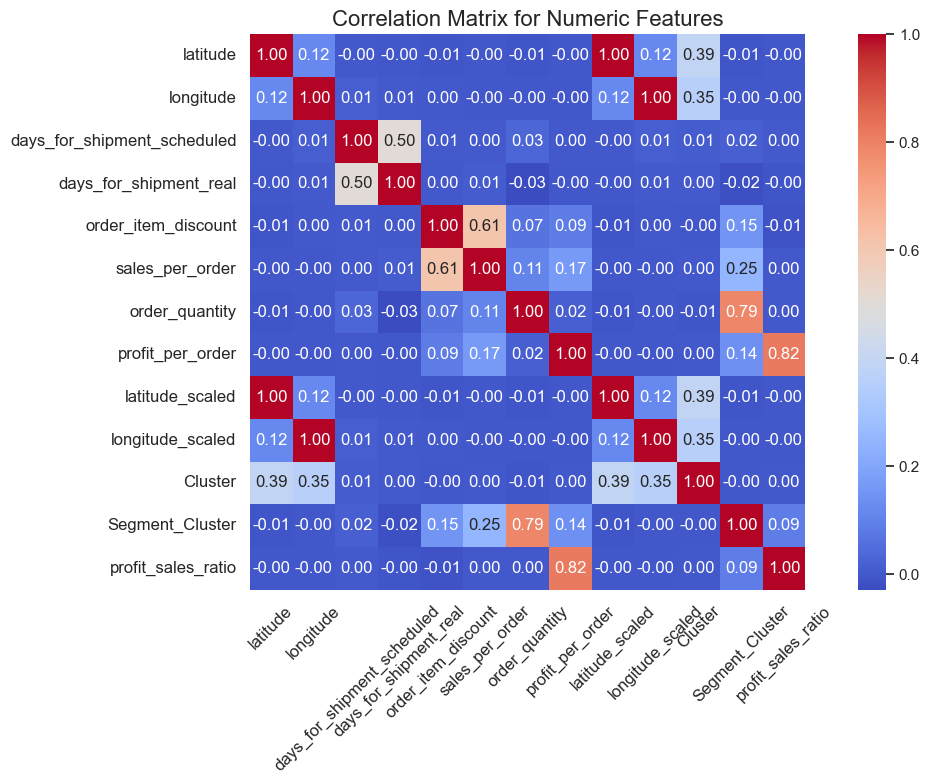

In [11]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True,
    square=True
)
plt.title('Correlation Matrix for Numeric Features', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


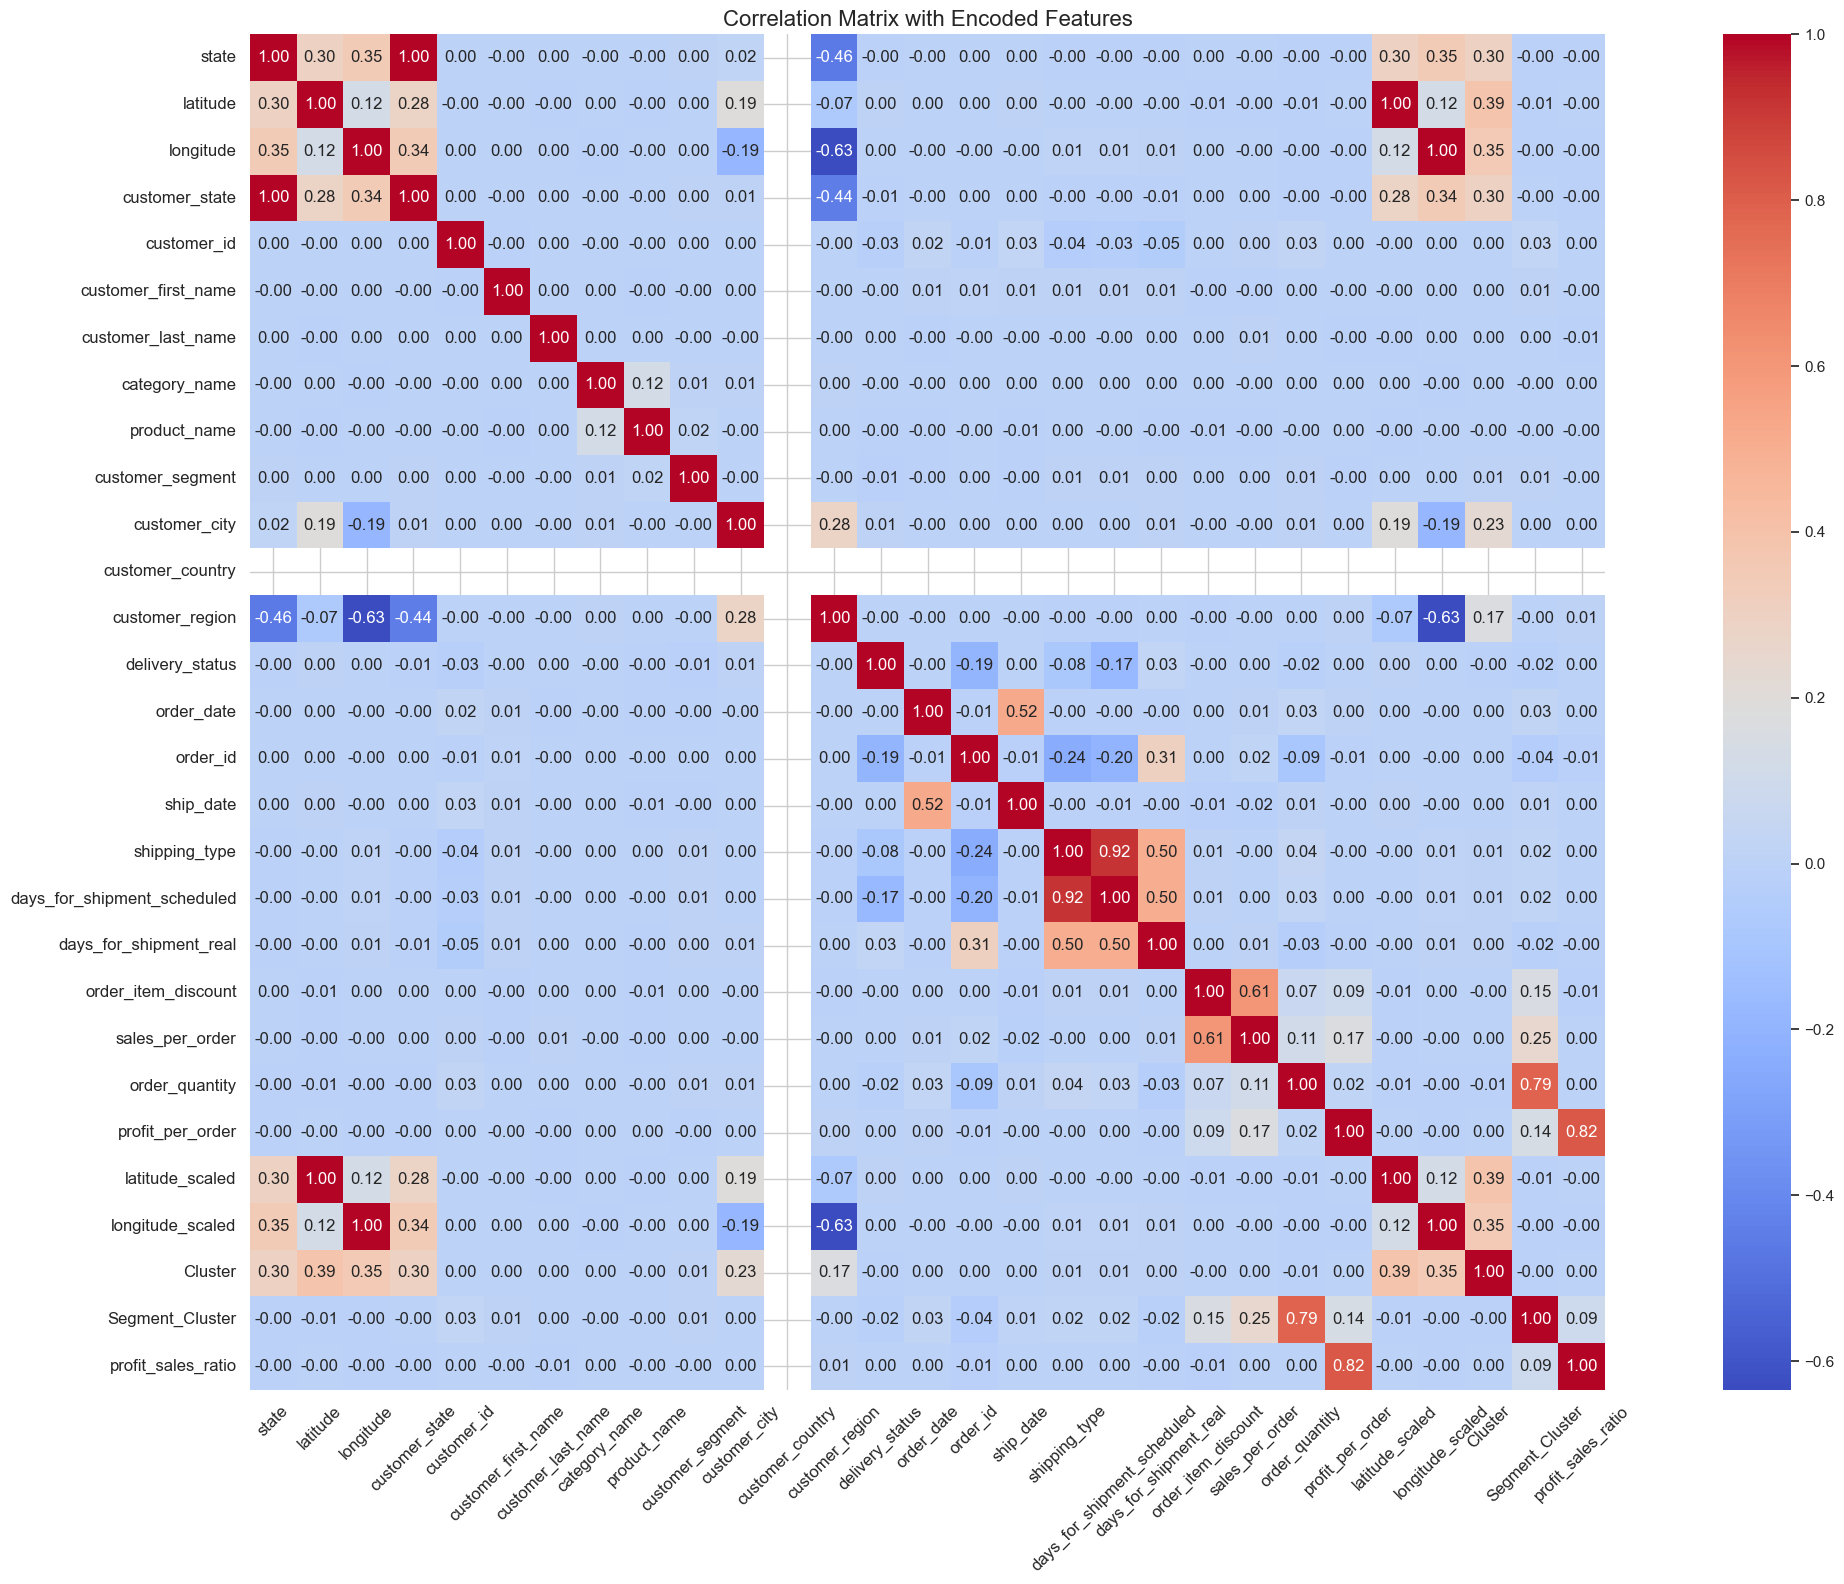

In [27]:
# Apply Label Encoding to all non-numeric columns
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Compute correlation matrix
correlation_matrix = data.corr()

# Plot heatmap as before
plt.figure(figsize=(24, 16))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True,
    square=True
)
plt.title('Correlation Matrix with Encoded Features', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Top factors affecting shipment delays:
 days_for_shipment_scheduled    0.504618
shipping_type                  0.503437
order_id                       0.305673
delivery_status                0.031722
customer_first_name            0.009691
Name: days_for_shipment_real, dtype: float64


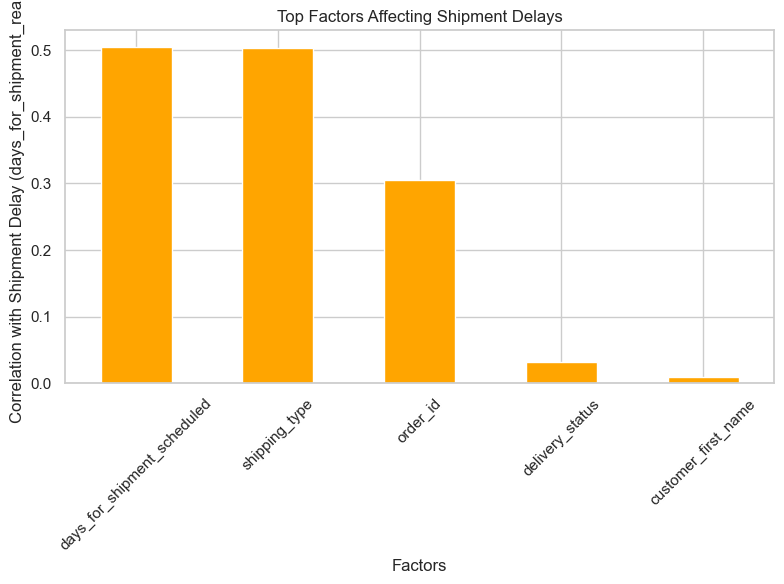

In [13]:
# Correlation analysis for shipment delays
delay_correlation = data.corr()['days_for_shipment_real'].sort_values(ascending=False)

# Filter top correlations for visualization (excluding 'days_for_shipment_real' itself)
top_delay_factors = delay_correlation.drop('days_for_shipment_real').nlargest(5)
print("Top factors affecting shipment delays:\n", top_delay_factors)

# Plot top factors affecting shipment delays
plt.figure(figsize=(8, 6))
top_delay_factors.plot(kind='bar', color='orange')
plt.title('Top Factors Affecting Shipment Delays')
plt.xlabel('Factors')
plt.ylabel('Correlation with Shipment Delay (days_for_shipment_real)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()